In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import extcolors
import os
from tqdm.notebook import tqdm
import PIL

5. Описание данных

Получено 10к картинок из категории «Ювелирные украшения», подкатегории «Часы и украшения».


В дополнение предоставлены данные c описанием каждого изображения: название, описание, внутренние id.

In [2]:
IMAGE_PATH = r'D:\Programms\Jupyter\AAA\Final_project_draft\aaa-jewellery-images'
df = pd.read_parquet(r'D:\Programms\Jupyter\AAA\Final_project_draft\aaa-jewellery-10k.parquet')
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(IMAGE_PATH, f'{x}.jpg'))

df.head()

,item_id,item_ext,microcat_id,subcategory_id,subcategory_name,row_num,image_id,title,description,image_path
0,1396927500894,2749537724,372698500001,11,Часы и украшения,9587,16494626170,Цепочки серебро,Продам цепочки и браслеты. \n1-цепочка якорная...,D:\Programms\Jupyter\AAA\Final_project_draft\a...
1,1396928252692,2804629841,372698750001,11,Часы и украшения,9586,16556447898,Ретро серьги колье украшения серебро янтарь,Набор ретро украшений из ссср\n\n!!! Большие с...,D:\Programms\Jupyter\AAA\Final_project_draft\a...
2,1396930250585,2716338406,372699000002,11,Часы и украшения,9585,16494558408,Планшеты для украшений,Планшеты для украшений на витрину\n1 шт- для ц...,D:\Programms\Jupyter\AAA\Final_project_draft\a...
3,1396933250988,2752477453,372699000002,11,Часы и украшения,9584,16494547834,Золой браслет орел,"Возможен безналичный расчёт 💳💳💳 вес 96,64 гр",D:\Programms\Jupyter\AAA\Final_project_draft\a...
4,1396934500373,2744570934,372698750002,11,Часы и украшения,9583,16494851465,"Золотой крестик. Бриллианты, рубины. В резерве",Золотой крестик с бриллиантами и рубинами. 585...,D:\Programms\Jupyter\AAA\Final_project_draft\a...


Целевой переменной в данном случае является сегментация изображений на предмет выделения основного объекта.

Пример выделения основного объекта:

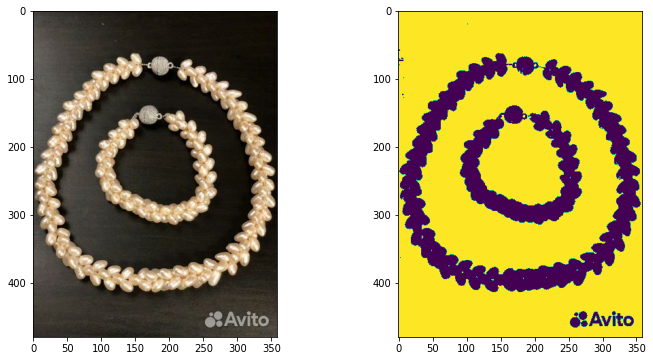

In [3]:
colors, total_pixel = extcolors.extract_from_path(df['image_path'][10])
test = colors[0][0]

plt.close()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow((plt.imread(df['image_path'][10])))

plt.subplot(1,2,2)
segmentation_mask = (plt.imread(df['image_path'][10])- np.array(test)).sum(-1)<250
plt.imshow(segmentation_mask)

plt.show()

Предварительный анализ исходного датасета показал следующее:
1) Среди картинок есть другие объекты(например коробки).

Решение задачи сегментации изображения может отличаться от основной массы задач, поэтому эти изображения могут негативно сказаться на качестве обучения и неверно интерпретироваться моделью.

В качестве решения можно отфильтровывать эти изображения при помощи небольшого числа текстового описания, которое характерно только для таких изображений, например, «Футляр».

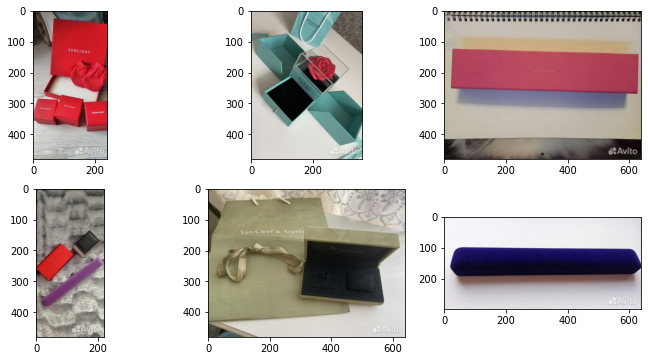

In [4]:
df_boxes = df[df.title.str.find('Футляр') != -1]

plt.close()
plt.figure(figsize=(12,6))
for i, curr_path in enumerate(df_boxes['image_path'][:6]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(plt.imread(curr_path))
plt.show()

2) На значительном количестве изображений украшение занимает менее 5% площади изображения.

Частично это связано с размерами самого украшения: тонкие и длинные украшения, например, цепи, в несложенным состоянии будут занимать мало площади изображения. Возможно, в этом случае улучшением изображения будет частичная обрезка и самого украшения для увеличения площади покрытия.

Другой типичный пример: маленькое изображение на большом фоне: это ключевой случай для нашей задачи, именно здесь решение представляет наибольший интерес и даст наибольший прирост к информативности изображений и, соответственно, бизнес-метрикам.

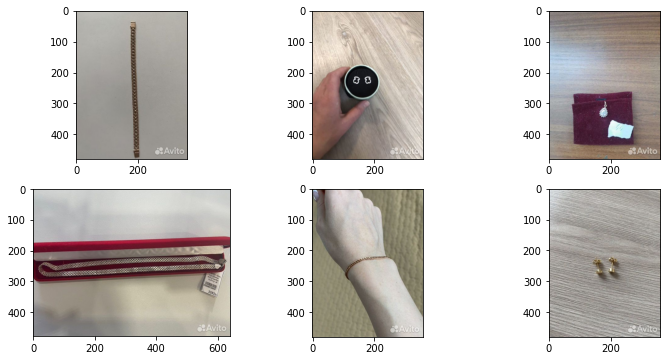

In [5]:
small_ids = [16983798513, 17180105100, 17115877823, 17154761340, 17203976941, 17320081448]
small_examples = df['image_path'][df['image_id'].isin(small_ids)]

plt.close()
plt.figure(figsize=(12,6))
for i, curr_path in enumerate(small_examples):
    plt.subplot(2, 3, i + 1)
    plt.imshow(plt.imread(curr_path))
plt.show()

3) Бывает несколько украшений на картинке.

В отдельных случаях можно несколько объектов интерпретировать как один цельный и решать задачу сегментации как для сложного украшения из нескольких элементов, но в других случаях объекты явно разделены фоном и могут представлять интерес для пользователя по отдельности.

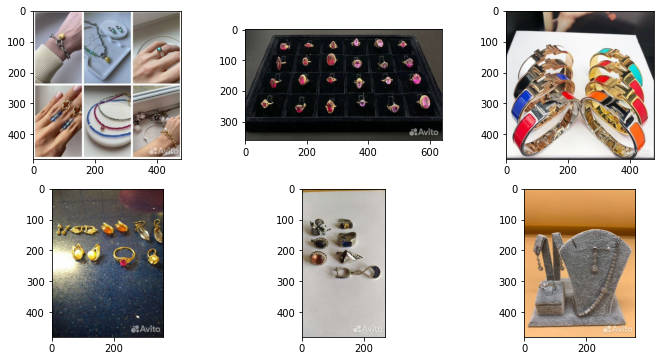

In [6]:
several_ids = [17302325342, 17334856366, 17338226415, 16704095809, 16717288718, 16729335091]
several_examples = df['image_path'][df['image_id'].isin(several_ids)]

plt.close()
plt.figure(figsize=(12,6))
for i, curr_path in enumerate(several_examples):
    plt.subplot(2, 3, i + 1)
    plt.imshow(plt.imread(curr_path))
plt.show()

**Всегда ли по картинке можно однозначно определить ответ?**

Нет, поскольку на изображении может быть не ювелирное украшение, на нем может быть несколько украшений.
В дополнение к этому стоит отметить, что сама задача сегментации применимо к замыливанию фона и обрезке изображения не требует абсолютной точности выделения объекта.

Для обработки исключений, описанных выше, возможно, актуальна подготовка дополнительной модели, которая определяет есть ли украшение на изображении или нет. И если «да», то только потом проводить более трудоемкую операцию по сегментации.

**В каком разрешении нужно решать задачу? Будут ли видны объекты в том разрешении, в котором вы будете подавать картинки в нейронную сеть?**

Обрезка и замыление изображения не слишком чувствительны к сохранению тонких деталей на границе объект-фон, поэтому в модель можно подавать изображение уменьшенного разрешения. При этом, однако, необходимо совершать для сгенерированной сегментационной маски обратное преобразование к изначальному размеру изображения.

Абсолютное большинство изображений имеют ширину в 480 пикселей и высоту 360. Эти размеры можно использовать в качестве входных для модели, чтобы минимизировать потерю информации при подаче изображения модели.

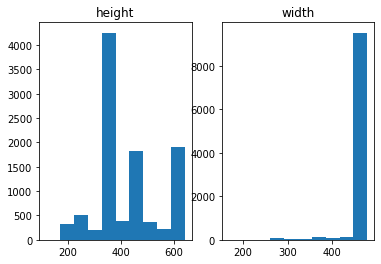

In [7]:
height, width = [], []
for curr_path in df['image_path'][:]:
    img = plt.imread(curr_path)
    width.append(img.shape[0])
    height.append(img.shape[1])
height = np.array(height)
width = np.array(width)

plt.close()

plt.subplot(1,2,1)
plt.hist(height, bins=10)
plt.title('height')

plt.subplot(1,2,2)
plt.hist(width, bins=10)
plt.title('width')

plt.show()

**Есть ли дисбаланс по визуальным признакам среди классов?**

В контексте нашей задачи не производится деления на классы, однако, если говорить о визуальных различиях между фоном и объектом интереса на изображении, то стоит отметить, что в фоне преобладают черный и белый цвета, а в объектах серый и желтые, связанные с цветами драгоценных металлов.

  0%|          | 0/100 [00:00<?, ?it/s]

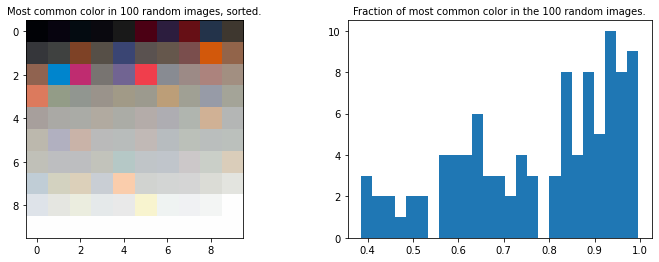

In [8]:
sample = np.random.choice(df['image_path'], 100)
most_filled = []
most_filled_portion = []

for img_path in tqdm(sample):
    colors, total_pixel = extcolors.extract_from_path(img_path)
    most_filled.append(colors[0][0])
    most_filled_portion.append(colors[0][1]/total_pixel)

most_filled = np.array(most_filled)
most_filled_portion = np.array(most_filled_portion)

# plt.close('all')
# plt.hist(most_filled_portion, histtype='stepfilled', bins=25)
# plt.show()

sort_idx = np.argsort((most_filled).sum(-1))

plt.close()
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.imshow(most_filled[sort_idx].reshape(10,-1,3))
# plt.imshow(most_filled[sort_idx].sum(-1).reshape(10,-1))
plt.title('Most common color in 100 random images, sorted.', fontdict={'size':10})

plt.subplot(1, 2, 2)
plt.hist(most_filled_portion, histtype='stepfilled', bins=25)
plt.title('Fraction of most common color in the 100 random images.', fontdict={'size':10})

plt.show()

**Какие аугментации можно использовать?**

- практически любые геометрические аугментации: поворот, перемещение, сжатие, перспектива, отражение
- незначительные аугментации по изменению цвета

Наша модель должна уметь верно определять объект на изображении вне зависимости от его положения, поэтому все геометрические аугментации дадут много дополнительной полезной информации. При этом мы не ожидаем значительного изменения цветовой гаммы объектов на настоящих изображениях, поэтому аугментации по изменению цвета призваны лишь имитировать разное освещение, небольшие изменения в цвете объекта.